In [14]:
from matplotlib import pyplot as plt
import numpy as np

In [15]:
import numpy as np

def compute_occupancy(threads_per_block,
                      registers_per_thread,
                      shared_mem_per_block,
                      gpu):

    blocks_threads = gpu['maxThreadsPerSM'] // threads_per_block
    blocks_limit = gpu['maxBlocksPerSM']
    blocks_shared = gpu['maxSharedMemPerSM'] // shared_mem_per_block if shared_mem_per_block > 0 else blocks_limit

    regs_per_block = registers_per_thread * threads_per_block
    blocks_registers = gpu['maxRegistersPerSM'] // regs_per_block if regs_per_block > 0 else blocks_limit

    blocks_per_sm = min(blocks_threads, blocks_limit, blocks_shared, blocks_registers)

    warps_per_block = int(np.ceil(threads_per_block / 32))
    total_warps = blocks_per_sm * warps_per_block

    occupancy = min(total_warps / gpu['maxWarpsPerSM'], 1.0)

    return {
        'blocks_due_to_threads': blocks_threads,
        'blocks_due_to_shared': blocks_shared,
        'blocks_due_to_registers': blocks_registers,
        'blocks_final': blocks_per_sm,
        'warps_per_block': warps_per_block,
        'total_warps': total_warps,
        'occupancy': occupancy
    }


In [16]:

gpu = {
    'maxThreadsPerSM': 1024,
    'maxThreadsPerBlock': 1024,
    'maxBlocksPerSM': 16,
    'maxWarpsPerSM': 64,
    'maxRegistersPerSM': 65536,
    'maxRegistersPerThread': 255,
    'maxSharedMemPerSM': 64*1024,
    'maxSharedMemPerBlock': 48*1024
}

# Example usage
result = compute_occupancy(
    threads_per_block=256,
    registers_per_thread=32,
    shared_mem_per_block=4096,
    gpu=gpu
)

print(result['occupancy'])

0.5


/tmp/ipykernel_5517/3965572721.py:8: RuntimeWarning: divide by zero encountered in scalar floor_divide
  blocks_threads = gpu['maxThreadsPerSM'] // threads_per_block


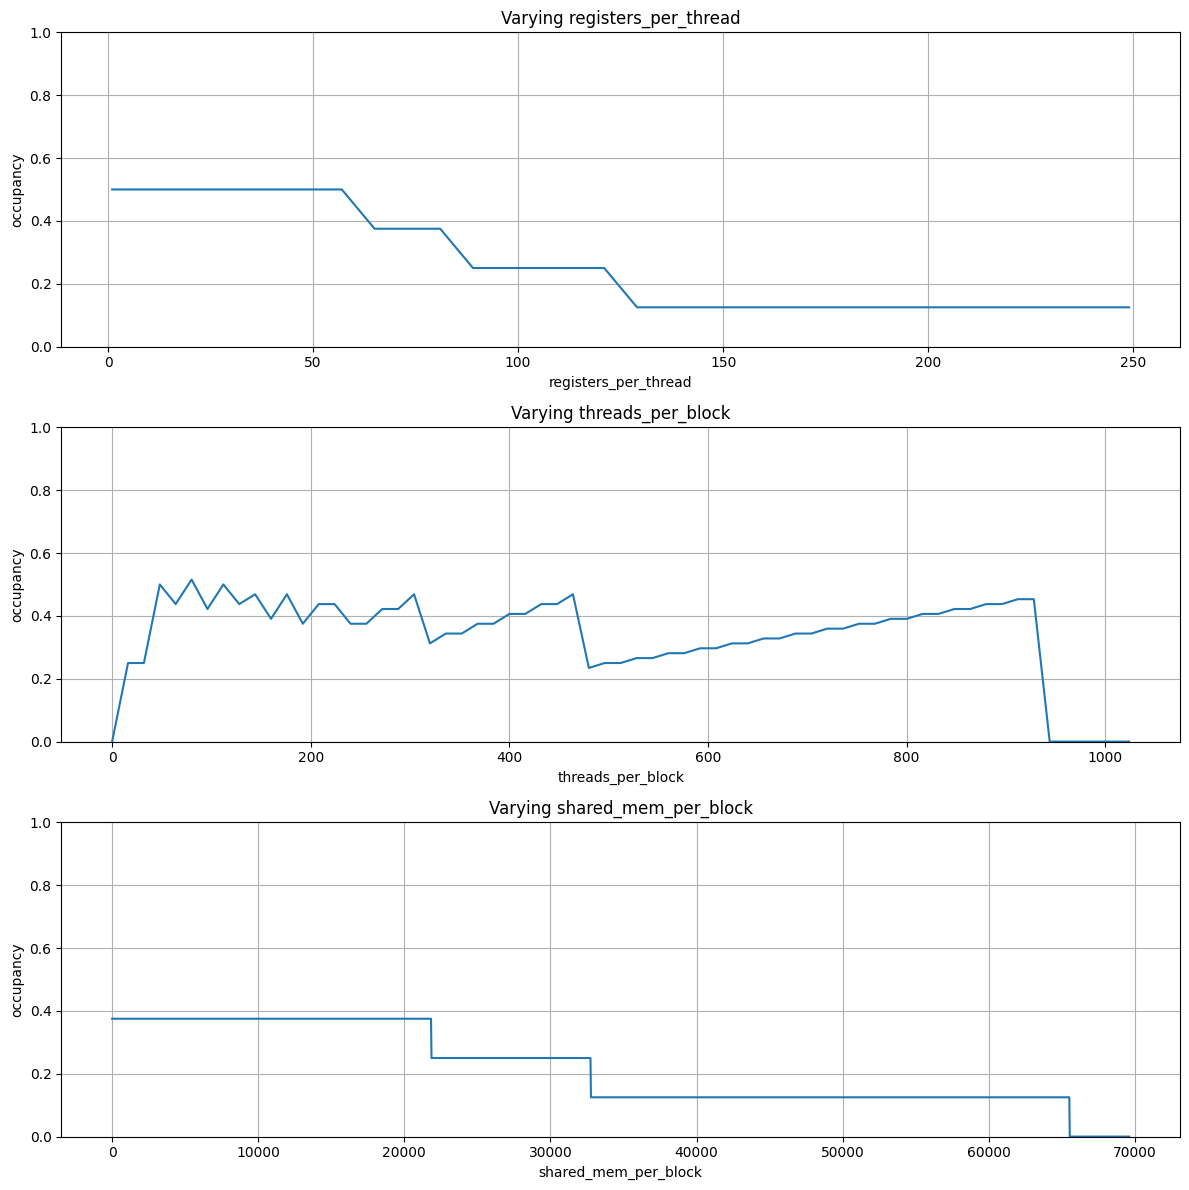

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def sweep_threads(gpu):
    values = np.arange(0, 1025, 16)
    occ = []
    for v in values:
        r = compute_occupancy(
            threads_per_block=v,
            registers_per_thread=70,
            shared_mem_per_block=0,
            gpu=gpu
        )
        occ.append(r['occupancy'])
    return values, occ

def sweep_registers(gpu):
    values = np.arange(1, 256, 8)
    occ = []
    for v in values:
        r = compute_occupancy(
            threads_per_block=256,
            registers_per_thread=v,
            shared_mem_per_block=0,
            gpu=gpu
        )
        occ.append(r['occupancy'])
    return values, occ

def sweep_shared(gpu):
    values = np.arange(1, 68*1024, 32)
    occ = []
    for v in values:
        r = compute_occupancy(
            threads_per_block=256,
            registers_per_thread=70,
            shared_mem_per_block=v,
            gpu=gpu
        )
        occ.append(r['occupancy'])
    return values, occ

threads_x, threads_y = sweep_threads(gpu)
regs_x, regs_y = sweep_registers(gpu)
shared_x, shared_y = sweep_shared(gpu)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))


axes[0].plot(regs_x, regs_y)
axes[0].set_title("Varying registers_per_thread")
axes[0].set_xlabel("registers_per_thread")
axes[0].set_ylabel("occupancy")
axes[0].set_ylim(0, 1)
axes[0].grid(True)

axes[1].plot(threads_x, threads_y)
axes[1].set_title("Varying threads_per_block")
axes[1].set_xlabel("threads_per_block")
axes[1].set_ylabel("occupancy")
axes[1].set_ylim(0, 1)
axes[1].grid(True)

axes[2].plot(shared_x, shared_y)
axes[2].set_title("Varying shared_mem_per_block")
axes[2].set_xlabel("shared_mem_per_block")
axes[2].set_ylabel("occupancy")
axes[2].set_ylim(0, 1)
axes[2].grid(True)

plt.tight_layout()
plt.show()
